In [1]:
#!/usr/bin/env python3

__author__ = "Gönül Aycı"
__email__ = "aycignl@gmail.com"
__license__ = "MIT"
__copyright__ = "Copyright 2024, https://github.com/aycignl/PracticalSnippets"


# Install (if needed) and import required libraries

In [2]:
!pip install shap mlflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import shap
import mlflow
import mlflow.sklearn
import seaborn as sns


# Load the Breast Cancer dataset

In [4]:
# Load the Breast Cancer dataset as a DataFrame
data = load_breast_cancer(as_frame=True)
X, y = data.data, data.target

# Combine the features and target into a single DataFrame
X_y_combined = pd.concat([X, y], axis=1)


# Correlation Matrix

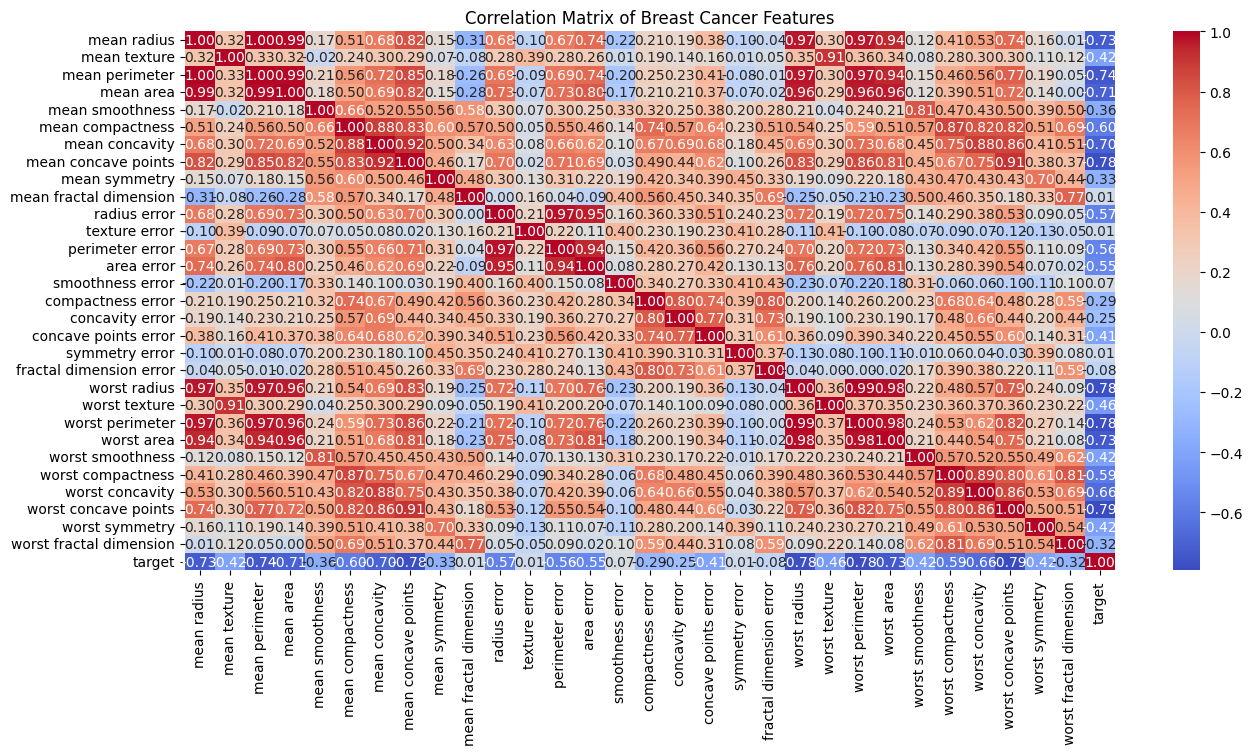

In [5]:
# Compute the correlation matrix
corr = X_y_combined.corr()

# Plot the heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(corr, annot=True, annot_kws={'size': 10}, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Breast Cancer Features')
plt.show()


In [6]:
# # No need to do imputation since X_y_combined is full
# X_y_combined.isnull().sum()


# Train and Test datasets split

In [7]:
# Set a random seed for reproducibility
rng_seed = 33

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng_seed)


# Train a Machine Learning model and compute feature importances. <br>


> Often, we desire to quantify the strength of the relationship between the predictors and the outcome. As the number of attributes becomes large, exploratory analysis of the all the predictors may be infeasible and concentrating on those with strong relationships with the outcome may be an effective triaging strategy. Ranking predictors in this manner can be very useful when sifting through large amounts of data. --- Chapter 18 [2].


In this script, we use the following different feature importance approaches:
*   **Coefficient Importance:** Coefficients represent the relationship between each feature and the target variable, with the magnitude indicating the strength of the relationship and the sign indicating the direction (positive or negative).
*   **Permutation Importance [3,4]:** It measures the increase in the model's prediction error after permuting the feature's values, thereby breaking the association between the feature and the outcome.
*   **SHAP (SHapley Additive exPlanations) Importance [5]:** Game theory based unified measure of feature importance. SHAP values explain the contribution of each feature to the prediction of each instance relative to the average prediction of the dataset.


In [8]:
# Define a Pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=rng_seed))
])

# Start MLflow experiment
mlflow.set_experiment("Breast Cancer Logistic Regression")

with mlflow.start_run():
    # Train the model
    # Since the main focus of this script is feature importance approaches,
    # we fit LogisticRegression and evaluate its performance using a single metric.
    # Feel free explore different ML algorithms and metrics.
    pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Test ROC-AUC: {roc_auc:.2f}")

    # Log model and metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.sklearn.log_model(pipeline, "logistic_regression_model")

    # Feature Importance - Coefficient Importance
    coefficient_importance = pipeline.named_steps['classifier'].coef_[0]

    # Feature Importance - Permutation Importance [3,4]
    permutation_importance_result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=rng_seed)
    permutation_importances = permutation_importance_result.importances_mean

    # Feature Importance - SHAP Values [5]
    # Correcting the approach to apply SHAP on the preprocessed data (after StandardScaler)
    X_train_transformed = pipeline.named_steps['std_scaler'].transform(X_train)
    X_test_transformed = pipeline.named_steps['std_scaler'].transform(X_test)
    explainer = shap.Explainer(pipeline.named_steps['classifier'], X_train_transformed)
    shap_values = explainer(X_test_transformed)
    # Take the absolute value of SHAP values before averaging them since we try
    # to understand the overall importance of a feature across the entire dataset.
    shap_importances = np.abs(shap_values.values).mean(axis=0)

    # Create Comparison Table
    importance_df = pd.DataFrame({
        'Feature': data.feature_names,
        'Coefficient Importance': coefficient_importance,
        'Permutation Importance': permutation_importances,
        'SHAP Importance': shap_importances
    }).sort_values(by='SHAP Importance', ascending=False)

    # Save the comparison table as CSV
    comparison_table_path = "feature_importance_comparison.csv"
    importance_df.to_csv(comparison_table_path, index=False)

    # Log Comparison Table
    mlflow.log_artifact(comparison_table_path)


2024/02/19 07:15:28 INFO mlflow.tracking.fluent: Experiment with name 'Breast Cancer Logistic Regression' does not exist. Creating a new experiment.


Test ROC-AUC: 0.98


Setuptools is replacing distutils.


# Show comparison between feature importance approaches



In [9]:
importance_df

,Feature,Coefficient Importance,Permutation Importance,SHAP Importance
21,worst texture,-1.581980,0.050585,1.219444
20,worst radius,-1.144182,0.014620,0.794217
27,worst concave points,-1.015553,0.014035,0.790020
6,mean concavity,-1.027481,0.017251,0.756396
7,mean concave points,-0.947286,0.015789,0.735976
22,worst perimeter,-1.002987,0.012573,0.717151
23,worst area,-1.089766,0.012281,0.694272
24,worst smoothness,-0.842686,0.010526,0.656705
26,worst concavity,-0.691222,0.011404,0.508589
11,texture error,0.654866,0.007310,0.493625


# Summarize the effects of all the features using SHAP


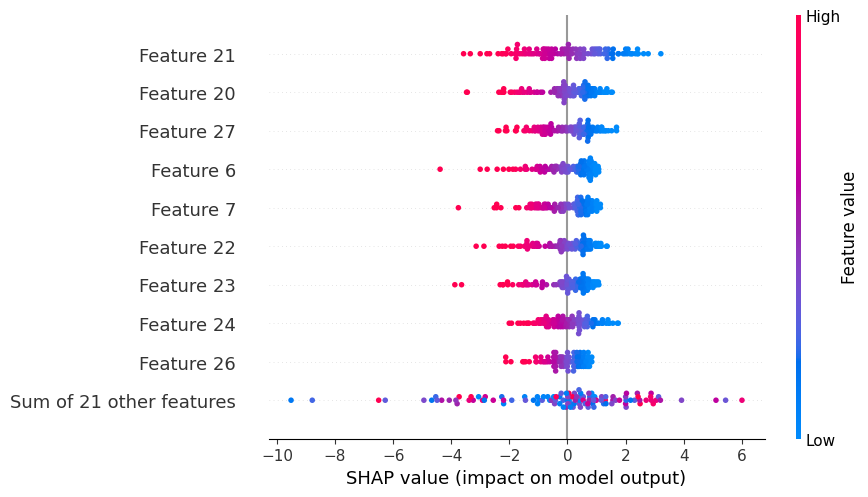

In [10]:
shap.plots.beeswarm(shap_values)


# References <br>
1.   Breast Cancer: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html
2.   Kuhn, M., & Johnson, K. Applied predictive modeling. Springer, 2018.
3.   Fisher, Aaron, Cynthia Rudin, and Francesca Dominici. “All models are wrong, but many are useful: Learning a variable’s importance by studying an entire class of prediction models simultaneously.” http://arxiv.org/abs/1801.01489
4.   Permutation Feature Importance: https://christophm.github.io/interpretable-ml-book/feature-importance.html
5.   SHAP: https://github.com/shap/shap